In [1]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)


tf.random.set_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams
from nltk.tokenize import RegexpTokenizer

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5

In [2]:
import tensorflow as tf
print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
True


In [3]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
path = 'ml_text_file.txt'
path3 = 'hp1.txt'
text1 = open(path , errors='ignore').read().lower()
#text2 = open(path2 , errors='ignore').read().lower()
text3 = open(path3 , errors='ignore').read().lower()
text = text1 + text3
print(type(text)) 
# print(text)
print('corpus length:', len(text))


 

print('corpus length:', len(text))

<class 'str'>
corpus length: 1082899
corpus length: 1082899


In [4]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(f'unique chars: {len(chars)}')

unique chars: 78


In [5]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(f'num training examples: {len(sentences)}')

num training examples: 360953


In [6]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [11]:
print(len(X)%52)

49


In [7]:
    from keras.callbacks import ModelCheckpoint, EarlyStopping
    from keras.layers import Dense, Activation, Dropout
    from keras.layers import LSTM, Input, Flatten, Bidirectional
    from keras.layers.normalization import BatchNormalization
    from keras.optimizers import Adam
    model = Sequential()
    #model.add(Bidirectional(LSTM(128, activation="relu",return_sequences=True),input_shape=(SEQUENCE_LENGTH, len(chars))))
    model.add(Bidirectional(LSTM(256,return_sequences=True),input_shape=(SEQUENCE_LENGTH, len(chars))))
    #model.add(Bidirectional(LSTM(128, activation="relu",return_sequences=True,batch_input_shape=(SEQUENCE_LENGTH+12, 8,16))))
    model.add(Bidirectional(LSTM(256)))
    model.add(Dropout(0.6))
    model.add(Dense(len(chars)))
    model.add(Activation('softmax'))
    
    optimizer = Adam(lr=0.001)
    #optimizer = RMSprop(lr=0.01)
    #callbacks=[EarlyStopping(patience=2, monitor='val_loss')]
    #model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("nextword4.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, verbose = 1)

logdir='logsnextword2'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

In [9]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 40, 512)           686080    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 78)                40014     
_________________________________________________________________
activation (Activation)      (None, 78)                0         
Total params: 2,301,006
Trainable params: 2,301,006
Non-trainable params: 0
_________________________________________________________________


In [10]:
#with tf.device('/cpu:0'):
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=64, epochs=50, shuffle=True, verbose=1, callbacks=[checkpoint, reduce, tensorboard_Visualization]).history

Epoch 1/50
5358/5358 [==============================] - 136s 24ms/step - loss: 2.3894 - accuracy: 0.3257 - val_loss: 1.6090 - val_accuracy: 0.5244

Epoch 00001: loss improved from inf to 2.08376, saving model to nextword4.h5
Epoch 2/50
5358/5358 [==============================] - 127s 24ms/step - loss: 1.7178 - accuracy: 0.4913 - val_loss: 1.4347 - val_accuracy: 0.5741

Epoch 00002: loss improved from 2.08376 to 1.67660, saving model to nextword4.h5
Epoch 3/50
5358/5358 [==============================] - 126s 24ms/step - loss: 1.5504 - accuracy: 0.5380 - val_loss: 1.3624 - val_accuracy: 0.5910

Epoch 00003: loss improved from 1.67660 to 1.53940, saving model to nextword4.h5
Epoch 4/50
5358/5358 [==============================] - 125s 23ms/step - loss: 1.4606 - accuracy: 0.5603 - val_loss: 1.3179 - val_accuracy: 0.6013

Epoch 00004: loss improved from 1.53940 to 1.45452, saving model to nextword4.h5
Epoch 5/50
5358/5358 [==============================] - 125s 23ms/step - loss: 1.3996 - 

In [52]:
model.save('keras_model4.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('nextword4.h5')
history = pickle.load(open("history.p", "rb"))

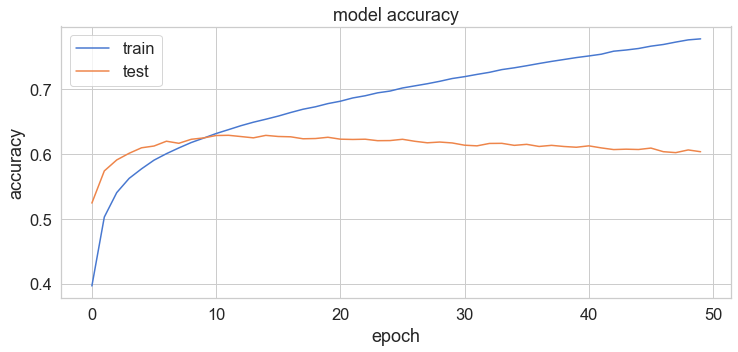

In [53]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [61]:
results = model.evaluate(X, y, batch_size=128,)

2820/2820 [==============================] - 41s 14ms/step - loss: 0.5651 - accuracy: 0.8305


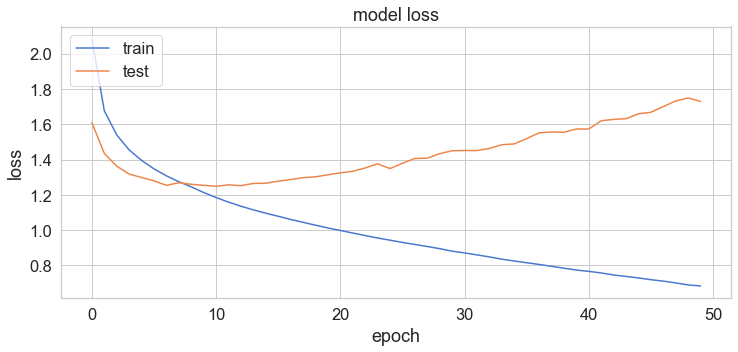

In [63]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [64]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x
prepare_input("This is an example of input for our LSTM".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [65]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [66]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [67]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [86]:
quotes = [
    "where is the class happening today at what.",
    "That which does not kill us makes us ready and makes us stronger.",
    "You cant seriously be considering to go and attack him",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is not a good day today for me as i was attacked by some people today and i got hurt badly" ,
    "The magical world had never seen such a powerful man untill the day he arrived"
    
]

In [87]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq,3))
    print()

where is the class happening today at wh


<ipython-input-65-bf39724b6161>:3: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds)


['at ', 'en ', 'y ']

that which does not kill us makes us rea
['lly ', 'ding ', 'soning ']

you cant seriously be considering to go 
['to ', 'back ', 'for ']

and those who were seen dancing were tho
['ught ', 'se ', 'me ']

it is not a good day today for me as i w
['as ', 'ould ', 'ill ']

the magical world had never seen such a 
['perfectly ', 'bright ', 'committed ']

